In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.16.3
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
# print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# tf.nn.softplus : log(1+e^x)
#参考keras.layers.core.Lambda(function, output_shape=None, mask=None, arguments=None)
#function为要实现的函数，该函数仅接受一个变量，即上一层的输出
#此处相当于起到一个激活函数的作用
customized_softplus = keras.layers.Lambda(lambda x : tf.nn.softplus(x))
print(customized_softplus([-10., -5., 0., 5., 10.]))

tf.Tensor([4.5417706e-05 6.7153489e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


In [6]:
# customized dense layer.
#通过继承Layer来自定义层
#build(input_shape):定义权重的方法
#call(x)：定义层功能的方法，参数为输入的张量
#compute_output_shape(input_shape)：如果层要修改输入的数据的shape，应该制定shape变化的方法，这个函数使得keras可以做自动shape的推断
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        """构建所需要的参数"""
        # x * w + b. input_shape:[None, a] w:[a,b]output_shape: [None, b]
        self.kernel = self.add_weight(name = 'kernel',
                                      shape = (input_shape[1], self.units),
                                      initializer = 'uniform',
                                      trainable = True)
        self.bias = self.add_weight(name = 'bias',
                                    shape = (self.units, ),
                                    initializer = 'zeros',
                                    trainable = True)
        super(CustomizedDenseLayer, self).build(input_shape)
    
    def call(self, x):
        """完成正向计算"""
        return self.activation(x @ self.kernel + self.bias)

model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu',
                         input_shape=x_train.shape[1:]),
    CustomizedDenseLayer(1),
    customized_softplus,
    # keras.layers.Dense(1, activation="softplus"),
    # keras.layers.Dense(1), keras.layers.Activation('softplus'),
])
model.summary()

#自定义损失函数
def customized_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true-y_pred))

# model.compile(loss="mean_squared_error", optimizer="sgd",
#               metrics=["mean_squared_error"])
model.compile(loss=customized_loss, optimizer="sgd",
              metrics=["mean_squared_error"])

In [11]:
"""
定义callbacks
可在官网查看https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf官网的api的tf.keras.callbacks可
关于回调函数的解释可参考keras中https://keras-cn.readthedocs.io/en/latest/other/callbacks/
windows下的路径提前创建好callbacks/plugins/profile文件夹
tensorboard版本不一致问题https://blog.csdn.net/qq_36368388/article/details/89295878按照这个修复就没有问题
安装tensorboard，然后输入命令tensorboard --logdir=log日志中包含.v2的文件夹
然后打开localhost:6006
"""
logdir = './callbacks/'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"regression_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    # keras.callbacks.ModelCheckpoint(output_model_file,
    #                                 save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
# callbacks = [keras.callbacks.EarlyStopping(
#     patience=5, min_delta=1e-2)]

In [14]:
#history即为fit函数的返回值
history = model.fit(x_train_scaled, y_train,
                    validation_data = (x_valid_scaled, y_valid),
                    epochs = 10,
                    callbacks = callbacks,
                    batch_size = 10000)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
10000/11610 [========================>.....] - ETA: 0s - loss: 0.5290 - mean_squared_error: 0.5290

11610/11610 [==============================] - 0s 9us/sample - loss: 0.5401 - mean_squared_error: 0.5401 - val_loss: 0.5766 - val_mean_squared_error: 0.5766


Epoch 2/10
10000/11610 [========================>.....] - ETA: 0s - loss: 0.5375 - mean_squared_error: 0.5375

11610/11610 [==============================] - 0s 6us/sample - loss: 0.5401 - mean_squared_error: 0.5401 - val_loss: 0.5766 - val_mean_squared_error: 0.5766


Epoch 3/10
10000/11610 [========================>.....] - ETA: 0s - loss: 0.5407 - mean_squared_error: 0.5407

11610/11610 [==============================] - 0s 6us/sample - loss: 0.5401 - mean_squared_error: 0.5401 - val_loss: 0.5766 - val_mean_squared_error: 0.5766


Epoch 4/10
10000/11610 [========================>.....] - ETA: 0s - loss: 0.5465 - mean_squared_error: 0.5465

11610/11610 [==============================] - 0s 6us/sample - loss: 0.5400 - mean_squared_error: 0.5400 - val_loss: 0.5765 - val_mean_squared_error: 0.5765


Epoch 5/10
10000/11610 [========================>.....] - ETA: 0s - loss: 0.5411 - mean_squared_error: 0.5411

11610/11610 [==============================] - 0s 6us/sample - loss: 0.5400 - mean_squared_error: 0.5400 - val_loss: 0.5765 - val_mean_squared_error: 0.5765


Epoch 6/10


10000/11610 [========================>.....] - ETA: 0s - loss: 0.5457 - mean_squared_error: 0.5457

11610/11610 [==============================] - 0s 3us/sample - loss: 0.5399 - mean_squared_error: 0.5399 - val_loss: 0.5765 - val_mean_squared_error: 0.5765


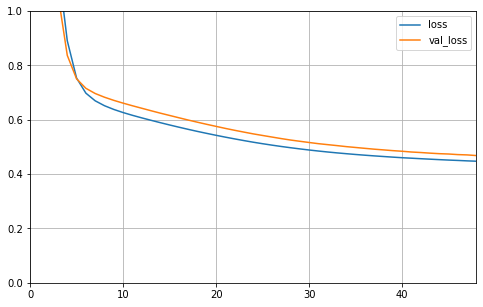

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [10]:
model.evaluate(x_test_scaled, y_test)

  32/5160 [..............................] - ETA: 0s - loss: 0.5097

1056/5160 [=====>........................] - ETA: 0s - loss: 0.4722

2496/5160 [=============>................] - ETA: 0s - loss: 0.4442

4736/5160 [==========================>...] - ETA: 0s - loss: 0.4668

5160/5160 [==============================] - 0s 35us/sample - loss: 0.4641


0.464081559070321